In [7]:
import numpy as np
import healpy as hp
import pandas as pd
from scipy import integrate
import astropy.io.fits as fits
import matplotlib.pyplot as plt
from astropy.cosmology import Planck15 as cosmo
from scipy.interpolate import interp1d
from scipy.optimize import curve_fit

In [8]:
from completeness import create_completeness_dataframe

In [6]:
%%bash
pip install healpy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.3/8.3 MB 2.6 MB/s eta 0:00:00


In [9]:
gkvInputCatv02_raw = fits.open('/home/farnoosh/farnoosh/Master_Thesis_all/Data/GAMA/gkvInputCatv02/gkvInputCatv02.fits')[1].data
SM_cat_raw = fits.open('/home/farnoosh/farnoosh/Master_Thesis_all/Data/GAMA/merged/StellarMass-gkvScience/mergedStellarMass-gkvScience')[1].data

drivedrc = np.loadtxt('/home/farnoosh/farnoosh/Master_Thesis_all/Data/GAMA/derivedrc.ascii', unpack = True)

In [10]:
nside=4096
z_max = 0.1 # ~430 Mpc
DEX = 0.25  # width of the mass bins
MASS_BINS = 10**np.arange(5,12.25,DEX)
HUBBLE_CST = 0.7


REGIONS_OF_SKY = {
    # 'G02': {'RAcen': (30.20, 38.80), 'DECcen': (-10.25, -3.72)},
    'G09': {'RAcen': (129.0, 141.0), 'DECcen': (-2.0, 3.0)},
    'G12': {'RAcen': (174.0, 186.0), 'DECcen': (-3.0, 2.0)},
    'G15': {'RAcen': (211.5, 223.5), 'DECcen': (-2.0, 3.0)},
    'G23': {'RAcen': (339.0, 351.0), 'DECcen': (-35.0, -30.0)},
}


GKV_MASKS = (
    (gkvInputCatv02_raw['uberclass'] == 1) &
    (gkvInputCatv02_raw['flux_rt'] > 10**-4.3) &
    (~gkvInputCatv02_raw['duplicate']) &

    (~gkvInputCatv02_raw['mask']) &
    (~gkvInputCatv02_raw['starmask'])
)
gkvInputCatv02 = gkvInputCatv02_raw[GKV_MASKS]

COMPLETENESS_MASKS = (
    (~SM_cat_raw['duplicate']) &
    (~SM_cat_raw['mask']) &
    (~SM_cat_raw['starmask']) &
    (SM_cat_raw['uberclass'] == 1) &
    (SM_cat_raw['mstar'] > 0) &
    (SM_cat_raw['flux_rt'] > 10**-4.3)
)

MASS_HISTOGRAM_MASKS = (
         (SM_cat_raw['uberclass'] == 1 ) & #galaxy
         (SM_cat_raw['duplicate'] == False) &
         (SM_cat_raw['mask'] == False) &
         (SM_cat_raw['starmask'] == False) &
         (SM_cat_raw['NQ'] > 2) &
         (SM_cat_raw['SC'] > 7) &
         (SM_cat_raw['mstar'] > 0) &
         (SM_cat_raw['Z'] < z_max) &
         (SM_cat_raw['flux_rt'] > 3631*10**(0.4*-19))
)

completeness_catalog = SM_cat_raw[COMPLETENESS_MASKS]
mass_histogram_catalog = SM_cat_raw[MASS_HISTOGRAM_MASKS]
print('mergedStellarMass_gkvScience, number of objects with SPEC_MASK:', len(completeness_catalog))
print('mass_histogram_catalog, number of objects with masks:',len(mass_histogram_catalog))

mergedStellarMass_gkvScience, number of objects with SPEC_MASK: 197083
mass_histogram_catalog, number of objects with masks: 18207


In [11]:
MS_regions = ['G09', 'G12', 'G15', 'G23']
MS = {region_name: REGIONS_OF_SKY[region_name] for region_name in MS_regions}

MS_SM_cat = {region_name: mass_histogram_catalog[(
    (mass_histogram_catalog['RAcen'] >= region_params['RAcen'][0]) & (mass_histogram_catalog['RAcen'] <= region_params['RAcen'][1]) &
    (mass_histogram_catalog['DECcen'] >= region_params['DECcen'][0]) & (mass_histogram_catalog['DECcen'] <= region_params['DECcen'][1])
) ] for region_name, region_params in MS.items()}

In [21]:
# Function to get the weighted histogram of the objects of each region
def get_weighted_mass_histogram(input_mass_completeness_dataframe: pd.DataFrame, region_name: str):
    filtered_by_region_dataframe = input_mass_completeness_dataframe[input_mass_completeness_dataframe['region'] == region_name]
    mass_column = filtered_by_region_dataframe['mstar']
    completeness_column = filtered_by_region_dataframe['completeness']
    volume_richard_curve = get_region_volume(region_name=region_name, mass_list=mass_column)
    weight = np.log(10)/ (volume_richard_curve * completeness_column * DEX)
    return np.histogram(mass_column, MASS_BINS, weights=weight)[0]

# Function to get the volume of each region
def get_region_volume(region_name: str, mass_list: list):
    region = REGIONS_OF_SKY[region_name]
    region_area = calculate_patch_area(patch=region, nside=4096)
    average_pixel_area = 4 * np.pi / (12 * nside**2)
    total_area_sphere = hp.nside2npix(nside) * average_pixel_area
    fraction_region = region_area / total_area_sphere
    return calculate_volume([Rrichard_curve(np.log10(mass)) for mass in mass_list], fraction_region)

# Function to calculate the area for a given patch
def calculate_patch_area(patch: dict, nside: int=4096):
    RA_min, RA_max = np.deg2rad(patch['RAcen'])
    DEC_min, DEC_max = np.deg2rad(patch['DECcen'])

    # Calculate the pixel indices for the given patch
    pix_indices = np.arange(hp.nside2npix(nside))
    pix_indices_patch = pix_indices[
        (hp.pixelfunc.pix2ang(nside, pix_indices)[0] >= np.pi/2 - DEC_max) &
        (hp.pixelfunc.pix2ang(nside, pix_indices)[0] <= np.pi/2 - DEC_min) &
        (hp.pixelfunc.pix2ang(nside, pix_indices)[1] >= RA_min) &
        (hp.pixelfunc.pix2ang(nside, pix_indices)[1] <= RA_max)
    ]

    # Calculate the area of the given patch using the average solid angle of a pixel
    average_pixel_area = 4 * np.pi / (12 * nside**2)
    patch_area = len(pix_indices_patch) * average_pixel_area

    return patch_area


x_r_curve = np.hstack((0, drivedrc[0], 1e13))
y_r_curve = np.hstack((0, drivedrc[1], drivedrc[1][-1]))



fun_MD = interp1d(x_r_curve, y_r_curve)
fun_MD(10**np.arange(9, 12, 0.1))
richard_curve = fun_MD

# Function to calculate volume (Mpc^3)
def calculate_volume(radius, fraction):
    return 4 / 3 * np.pi * np.power(radius, 3)  * fraction

# Function to calculate error
def calculate_error(y_data, number_of_galaxies):
    return np.sqrt((y_data * number_of_galaxies**(-1/2))**2 + (y_data * 0.043)**2)

In [19]:
# Fig 11 _ driver mass density
x = [
    902853.3178196718, 2179811.1147120153, 3998911.083012657, 7671532.127974614,
    16722490.999429416, 36920509.342651345, 63540600.90067689, 140287194.6094133,
    292428312.0759782, 586647539.9157286, 1055791991.4054358, 2159026510.5162964,
    3645187174.622795, 7173909515.027555, 13762465877.649588, 23989861421.352215,
    41817611475.449974, 65812426830.55004, 78700557458.04645, 106936561046.73,
    135444521246.77594, 164051118428.67163, 191228843284.58127, 224337319122.0254,
    275211849545.6421, 291495902887.30774, 348579913532.66064, 376347867110.2604,
    416842758045.2533, 428695986893.9014, 438695986893.9014, 441694884227.59576
]

y = [
    0.29078994864869623, 0.19637575836296267, 0.13627008410527156, 0.09972955112467789,
    0.0679635394757627, 0.04430240339173305, 0.036399541607199104, 0.025931489312813097,
    0.017830973948638692, 0.013400932614203342, 0.01016351592168385, 0.008804734647939537,
    0.007170392470115855, 0.006212227232606965, 0.005626823156035961, 0.0047478311501422885,
    0.0037982112588196147, 0.0029592012993311053, 0.0023480970386531626, 0.001518504160019035,
    0.0009478567185224438, 0.0006409572706234328, 0.0003966133445348753, 0.00023475242773287076,
    0.00012600191160519128, 0.00008830961428501859, 0.000047824942656908086, 0.000027813186027539184,
    0.00001690891507430546, 0.000012611249580038988, 0.000012611249580038988, 0.000009746138910728958
]


# Fig 10 _ Original richard curve data of driver data ( co-moving distance )
xx = [6.58751775e+05, 8.41173922e+05, 1.07411258e+06, 1.37155682e+06,
  1.75136960e+06, 2.23636048e+06, 3.08477958e+06, 4.21696503e+06,
  4.21696503e+06, 4.21696503e+06, 6.21016942e+06, 8.48944522e+06,
  1.30863341e+07, 1.61623720e+07, 2.04667965e+07, 2.63531844e+07,
  3.53544737e+07, 4.40437959e+07, 5.76464251e+07, 7.16374935e+07,
  9.35310171e+07, 1.17457622e+08, 1.52504852e+08, 1.94736636e+08,
  2.48663284e+08, 3.10544895e+08, 3.91288994e+08, 4.78987540e+08,
  5.72182274e+08, 6.98869127e+08, 8.25620375e+08, 9.53923782e+08,
  1.07794270e+09, 1.22260516e+09, 1.46435161e+09, 1.71311926e+09,
  1.92813447e+09, 2.10383295e+09, 2.34633613e+09, 2.53925237e+09,
  2.83417099e+09, 3.10453291e+09, 3.31528708e+09, 3.61901223e+09,
  3.91173572e+09, 4.31781521e+09, 4.62119242e+09, 4.88519872e+09,
  5.29208508e+09, 5.58200052e+09, 6.35461092e+09]

yy = [9.74008000e+00, 1.00869500e+01, 9.62305000e+00, 9.09877000e+00,
  1.09550400e+01, 9.83563000e+00, 1.26004500e+01, 1.39291700e+01,
  1.39291700e+01, 1.39291700e+01, 1.65427700e+01, 1.97782700e+01,
  2.42844700e+01, 2.50349000e+01, 2.81025500e+01, 3.15290600e+01,
  3.64587500e+01, 4.05578200e+01, 4.63526700e+01, 5.08202500e+01,
  5.78317500e+01, 6.47738100e+01, 7.31235900e+01, 8.31227500e+01,
  9.14471800e+01, 1.02534530e+02, 1.15264210e+02, 1.24864230e+02,
  1.38244940e+02, 1.51838470e+02, 1.65006440e+02, 1.75857460e+02,
  1.88284540e+02, 1.96768830e+02, 2.13419570e+02, 2.30790730e+02,
  2.41099640e+02, 2.54989640e+02, 2.68414190e+02, 2.77783400e+02,
  2.93443750e+02, 3.03639460e+02, 3.16292760e+02, 3.28740780e+02,
  3.39903130e+02, 3.56593290e+02, 3.66836310e+02, 3.78807800e+02,
  3.90282520e+02, 4.01664920e+02, 4.17800910e+02]

In [22]:
def Rrichard_curve(x):
    """
    Richards curve from GAMA based on Table 5, Eq. 2 from Driver et al. 2022
    :param x: log10 of stellar mass limit
    :return: co moving distance  in Mpc
    """
    A = -0.016
    K = 2742.0
    C = 0.9412
    B = 1.1483
    M = 11.815
    nu = 1.691
    y = A + (K - A) / (C + np.exp(-B * (x - M))) ** (1 / nu)
    return y


# Create an array of the stellar masses from the catalog
mstar_values = mass_histogram_catalog['mstar']

# Calculate the corresponding Richards curve values for each stellar mass
richards_curve_values = Rrichard_curve(np.log10(mstar_values))

In [23]:

completeness_all_df = pd.DataFrame()

# Loop over regions and create completeness DataFrames
for region_name, region_params in REGIONS_OF_SKY.items():
    completeness_region_df = create_completeness_dataframe(big_survey=gkvInputCatv02,
                                                           small_survey=completeness_catalog,
                                                           flux_type='flux_rt',
                                                           region=region_name)
    completeness_region_df['region'] = region_name
    completeness_all_df = pd.concat([completeness_all_df, completeness_region_df], ignore_index=True)
print(completeness_all_df)

/home/farnoosh/Nextcloud/Master_Thesis_all/codes/jupyternotebooks/completeness.py:34: RuntimeWarning: invalid value encountered in true_divide
  return np.cumsum(number_of_obj_small_survey)/np.cumsum(number_of_obj_big_survey)
/home/farnoosh/Nextcloud/Master_Thesis_all/codes/jupyternotebooks/completeness.py:34: RuntimeWarning: invalid value encountered in true_divide
  return np.cumsum(number_of_obj_small_survey)/np.cumsum(number_of_obj_big_survey)
/home/farnoosh/Nextcloud/Master_Thesis_all/codes/jupyternotebooks/completeness.py:34: RuntimeWarning: invalid value encountered in true_divide
  return np.cumsum(number_of_obj_small_survey)/np.cumsum(number_of_obj_big_survey)
/home/farnoosh/Nextcloud/Master_Thesis_all/codes/jupyternotebooks/completeness.py:34: RuntimeWarning: invalid value encountered in true_divide
  return np.cumsum(number_of_obj_small_survey)/np.cumsum(number_of_obj_big_survey)


                 uberID  completeness region
0       138021052006945      0.962803    G09
1       131010293406270      0.902471    G09
2       136000563202354      0.899956    G09
3       130020205007803      0.958275    G09
4       132990039308055      0.957683    G09
...                 ...           ...    ...
197076  341690286909859      0.767916    G23
197077  339670781606938      0.722778    G23
197078  346700890705873      0.851806    G23
197079  338690341704233      0.872967    G23
197080  342670256912301      0.634596    G23

[197081 rows x 3 columns]


In [24]:
mass_histogram_catalog_dataframe = pd.DataFrame()
mass_histogram_catalog_dataframe['uberID'] = mass_histogram_catalog['uberID'].byteswap().newbyteorder()
mass_histogram_catalog_dataframe['mstar'] = mass_histogram_catalog['mstar'].byteswap().newbyteorder()
mass_histogram_catalog_dataframe['comovingdist'] = mass_histogram_catalog['comovingdist'].byteswap().newbyteorder()


In [25]:
# Merge completeness DataFrame with mass_histogram_catalog_dataframe based on 'uberID'
full_mass_completeness_dataframe = pd.merge(mass_histogram_catalog_dataframe, completeness_all_df,
                            on='uberID', how='left')
print(full_mass_completeness_dataframe)

                uberID         mstar  comovingdist  completeness region
0      341690300008314  1.087142e+10    326.537109      0.882700    G23
1      131010212204000  9.152709e+09    190.752213      0.972318    G09
2      220991153710094  2.215012e+09    247.607788      0.971233    G15
3      177990619002373  3.160768e+09    330.653473      0.974572    G12
4      180990137108158  3.543520e+10    271.900909      0.980619    G12
...                ...           ...           ...           ...    ...
18202  178000570905838  8.807055e+09    334.273346      0.977612    G12
18203  134991179202696  2.234503e+09    304.089417      0.961148    G09
18204  175000183703788  8.990258e+09    392.689514      0.979928    G12
18205  179990595910710  1.569621e+10    347.618042      0.979674    G12
18206  135000832810514  9.149594e+07    111.699997      0.958134    G09

[18207 rows x 5 columns]


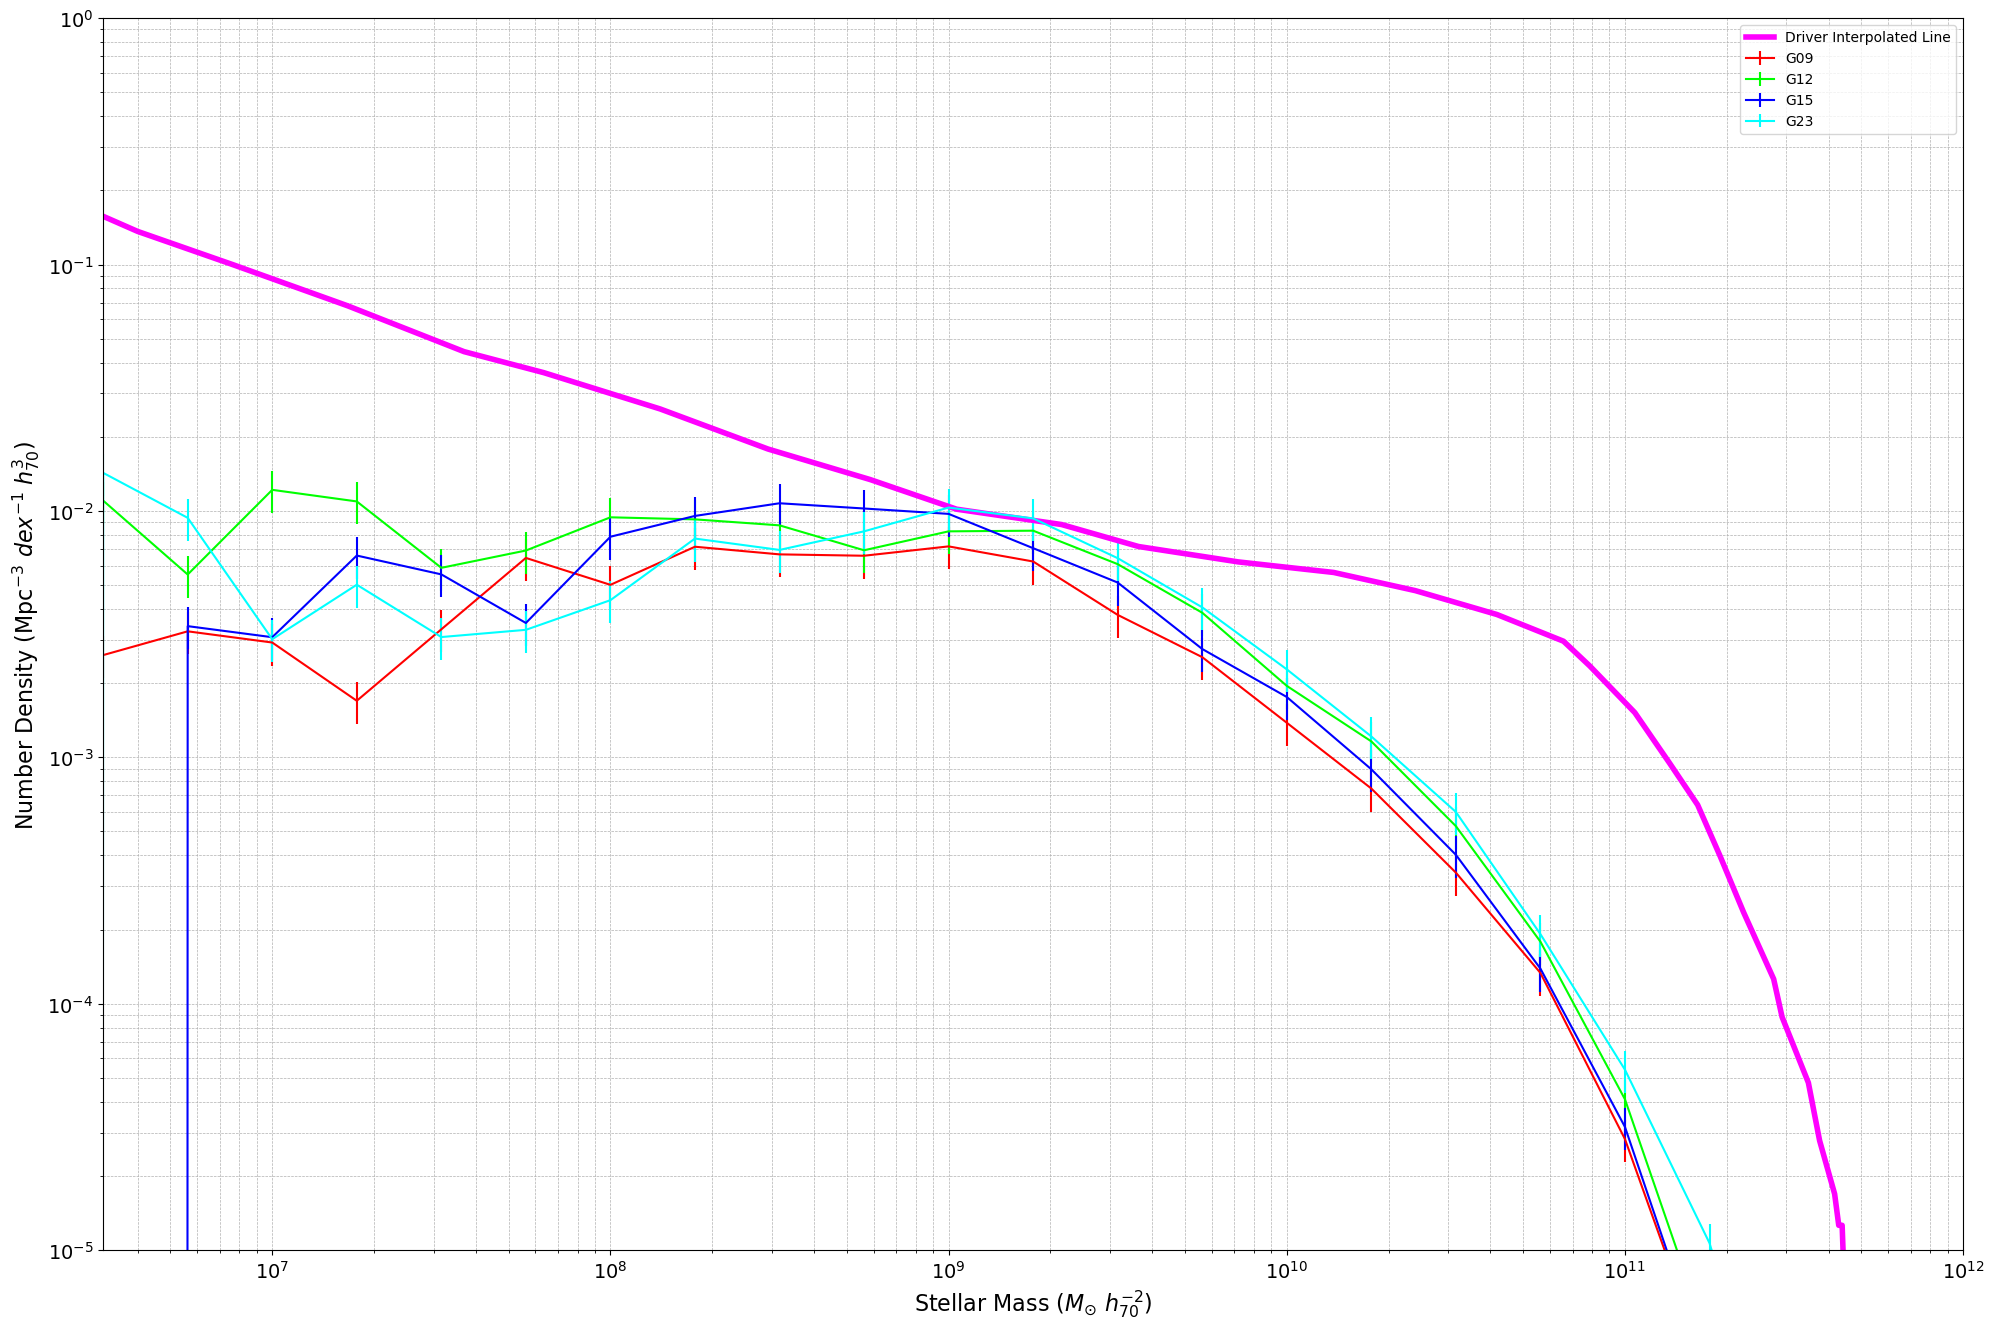

[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 2.76642123e-03 1.81676972e-03
 5.84417001e-04 9.72471127e-04 5.96312217e-04 6.37989131e-04
 8.41651403e-04 1.49679309e-03 1.34614221e-03 1.60137152e-03
 1.99975329e-03 1.80705368e-03 1.24608483e-03 7.87270805e-04
 4.40998780e-04 2.35572640e-04 1.16330109e-04 3.71456110e-05
 1.04605009e-05 2.06946727e-06 1.55535451e-07 0.00000000e+00]


In [27]:
region_colors = {'G09': 'red', 'G12': 'lime', 'G15': 'blue', 'G23': 'cyan'}
fig, ax = plt.subplots(figsize=(24, 16))
for region_name in REGIONS_OF_SKY.keys():
    mass_hist = get_weighted_mass_histogram(input_mass_completeness_dataframe=full_mass_completeness_dataframe, region_name=region_name)
    error = calculate_error(mass_hist, len(mass_hist))      # not correct

    plt.errorbar(
        MASS_BINS[:-1],
        mass_hist,
        yerr=error,
        label=region_name,
        color=region_colors.get(region_name),
    )

plt.plot(x, y, label='Driver Interpolated Line', color='magenta', linewidth=4)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Stellar Mass ($M_{\odot} \ h_{70}^{-2}$)', fontsize=16)
plt.ylabel('Number Density ($\mathrm{Mpc}^{-3} \ dex^{-1} \ h_{70}^{3}$)', fontsize=16)
plt.xlim((10**6.5, 10**12))
plt.ylim((1e-5, 1e0))
plt.tick_params(axis='both', which='major', labelsize=14)
plt.legend()
ax.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.show()
print(calculate_error(mass_hist, len(mass_hist)))


In [62]:
print(np.log(10))

2.302585092994046


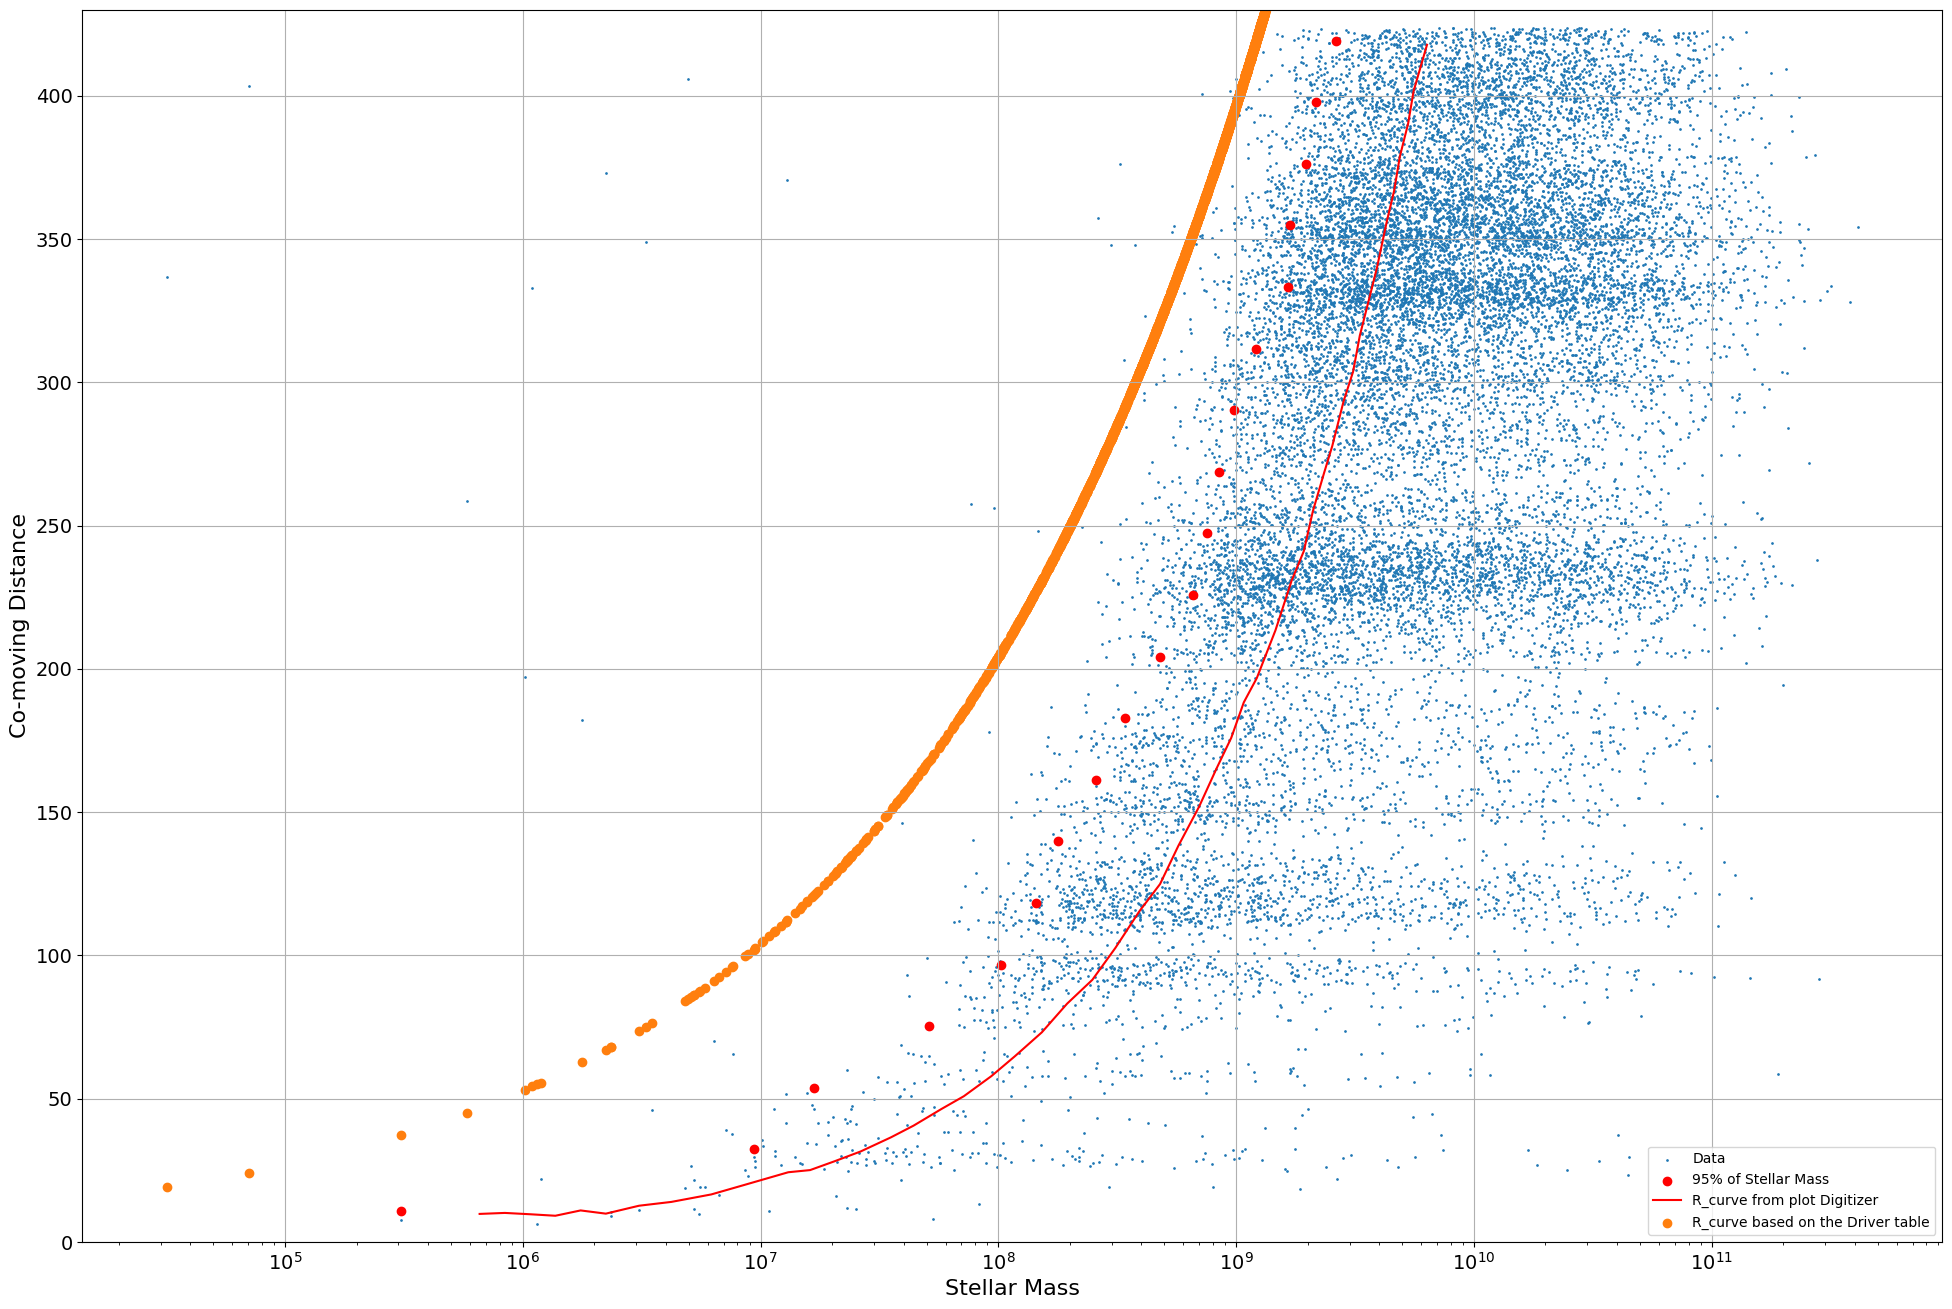

In [63]:
mstar_values = mass_histogram_catalog['mstar']
co_move = mass_histogram_catalog['comovingdist']

num_bins = 20
bin_width = 430 / num_bins

bin_center = []
mass_percentile = []

fig, ax = plt.subplots(figsize=(24, 16))

for i in range(num_bins):
    bin_start = i * bin_width
    bin_end = (i + 1) * bin_width
    objects_in_bin = mstar_values[(co_move >= bin_start) & (co_move < bin_end)]
    sorted_masses = np.sort(objects_in_bin)[::-1]
    idx_95th_percentile = int(0.95 * len(sorted_masses))

    if len(sorted_masses) > 0:
        mass_95th_percentile = sorted_masses[idx_95th_percentile]
        bin_center.append((bin_start + bin_end) / 2)
        mass_percentile.append(mass_95th_percentile)

plt.scatter(mstar_values, co_move, s=0.9, label='Data')
plt.scatter(mass_percentile, bin_center, color='red', marker='o', label='95% of Stellar Mass')
plt.plot(xx, yy, color ='red', label='R_curve from plot Digitizer')
plt.scatter(mstar_values, richards_curve_values, label='R_curve based on the Driver table')
plt.xlabel('Stellar Mass', fontsize=16)
plt.ylabel('Co-moving Distance', fontsize=16)
plt.xscale('log')
plt.ylim(0, 430)
plt.tick_params(axis='both', which='major', labelsize=14)
plt.legend()
plt.grid(True)
plt.show()


In [64]:
print(mass_percentile)

[308148.88, 9356760.0, 16846820.0, 51098160.0, 102411440.0, 144580110.0, 178999330.0, 258196660.0, 340204130.0, 480238660.0, 658951040.0, 758150800.0, 848885300.0, 984715970.0, 1211997600.0, 1651121700.0, 1686628500.0, 1966464600.0, 2169247500.0, 2626552300.0]


/home/farnoosh/.local/lib/python3.10/site-packages/scipy/interpolate/_interpolate.py:698: RuntimeWarning: invalid value encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]


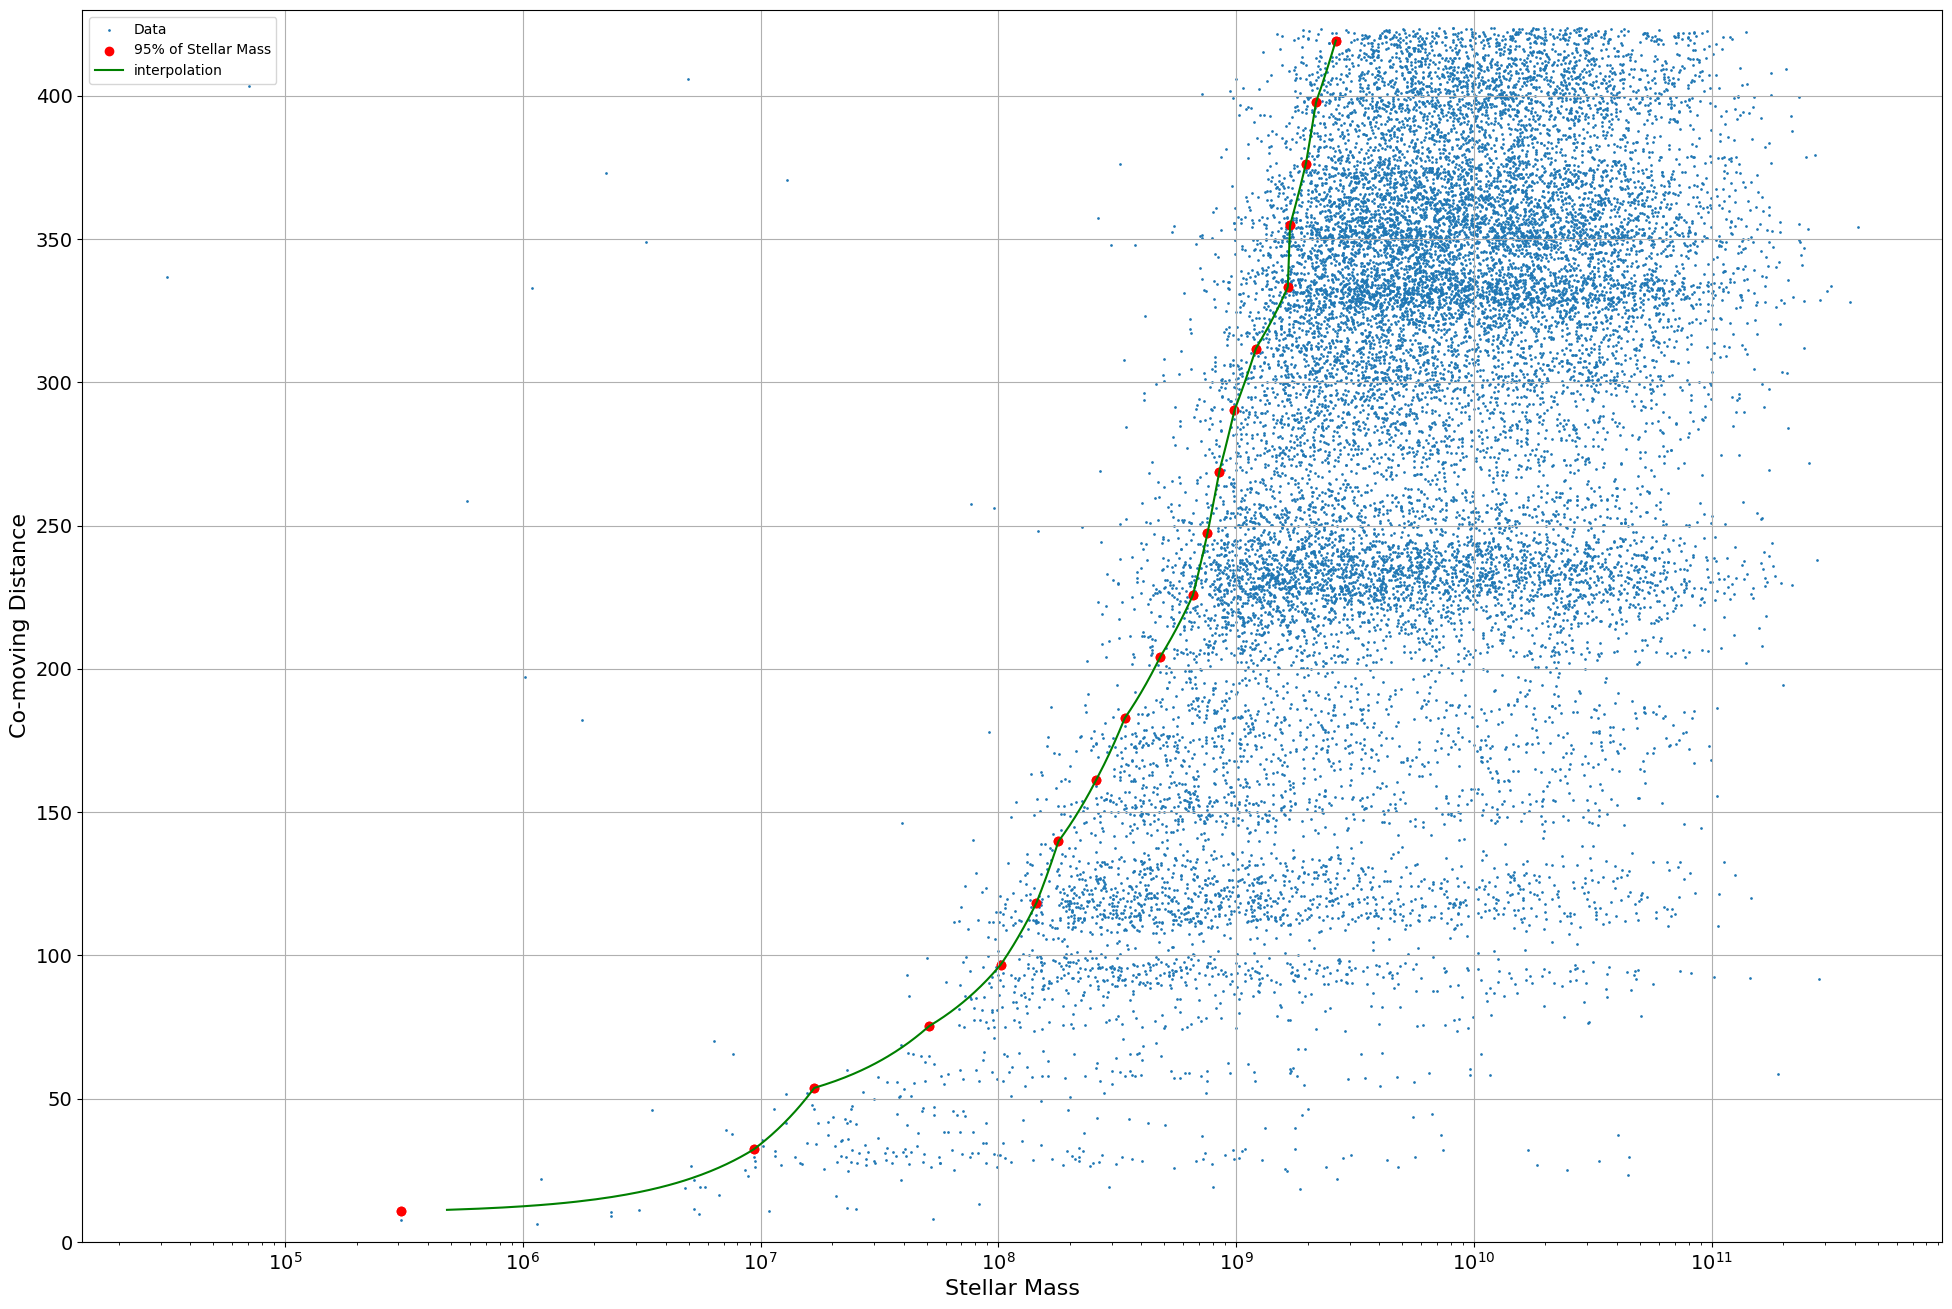

[10.75, 32.25, 53.75, 75.25, 96.75, 118.25, 139.75, 161.25, 182.75, 204.25, 225.75, 247.25, 268.75, 290.25, 311.75, 333.25, 354.75, 376.25, 397.75, 419.25, 10.75, 32.25, 53.75, 75.25, 96.75, 118.25, 139.75, 161.25, 182.75, 204.25, 225.75, 247.25, 268.75, 290.25, 311.75, 333.25, 354.75, 376.25, 397.75, 419.25]


In [65]:
fig, ax = plt.subplots(figsize=(24, 16))

for i in range(num_bins):
    bin_start = i * bin_width
    bin_end = (i + 1) * bin_width

    objects_in_bin = mstar_values[(co_move >= bin_start) & (co_move < bin_end)]
    sorted_masses = np.sort(objects_in_bin)[::-1]
    idx_95th_percentile = int(0.95 * len(sorted_masses))

    if len(sorted_masses) > 0:
        mass_95th_percentile = sorted_masses[idx_95th_percentile]
    else:
        mass_95th_percentile = np.nan

    bin_center.append((bin_start + bin_end) / 2)
    mass_percentile.append(mass_95th_percentile)

plt.scatter(mstar_values, co_move, s=0.9, label='Data')
plt.scatter(mass_percentile, bin_center, color='red', marker='o', label='95% of Stellar Mass')
interp_func = interp1d(bin_center, mass_percentile, kind='linear')

x_interp = np.linspace(min(bin_center), max(bin_center), 1000)
y_interp = interp_func(x_interp)
plt.plot(y_interp, x_interp, color='green', label='interpolation')
plt.xlabel('Stellar Mass', fontsize=16)
plt.ylabel('Co-moving Distance', fontsize=16)
plt.xscale('log')
plt.ylim(0, 430)
plt.tick_params(axis='both', which='major', labelsize=14)
plt.legend()
plt.grid(True)
plt.show()
print(bin_center)

In [66]:
print()

In [67]:
def Rrichard_curve(x, A, K, C, B, M, nu):
    return A + (K - A) / (C + np.exp(-B * (x - M))) ** (1 / nu)

mstar_values = mass_histogram_catalog['mstar']
co_move = mass_histogram_catalog['comovingdist']

# Binning and finding 95th percentile
num_bins = 20
bin_width = 430 / num_bins

bin_center = []
mass_percentile = []

for i in range(num_bins):
    bin_start = i * bin_width
    bin_end = (i + 1) * bin_width
    objects_in_bin = mstar_values[(co_move >= bin_start) & (co_move < bin_end)]
    sorted_masses = np.sort(objects_in_bin)[::-1]
    idx_95th_percentile = int(0.95 * len(sorted_masses))

    if len(sorted_masses) > 0:
        mass_95th_percentile = sorted_masses[idx_95th_percentile]
    else:
        mass_95th_percentile = np.nan

    bin_center.append((bin_start + bin_end) / 2)
    mass_percentile.append(mass_95th_percentile)


# Curve fitting
popt, pcov = curve_fit(Rrichard_curve, np.log10(bin_center), mass_percentile)

# Plotting
plt.figure(figsize=(12, 8))
plt.scatter(mstar_values, co_move, s=0.3, label='Data')
plt.scatter(bin_center, mass_percentile, color='red', marker='o', label='95% of Stellar Mass')
x_fit = np.linspace(min(bin_center), max(bin_center), 1000)
plt.plot(x_fit, Rrichard_curve(np.log10(x_fit), *popt), color='green', label='Richard Curve Fit')
plt.xlabel('Stellar Mass', fontsize=16)
plt.ylabel('Co-moving Distance', fontsize=16)
plt.xscale('log')
plt.ylim(0, 430)
plt.tick_params(axis='both', which='major', labelsize=14)
plt.legend()
plt.grid(True)
plt.show()

# Print the optimized parameters
print("Optimized Parameters:")
print("A =", popt[0])
print("K =", popt[1])
print("C =", popt[2])
print("B =", popt[3])
print("M =", popt[4])
print("nu =", popt[5])

/tmp/ipykernel_5797/296560040.py:2: RuntimeWarning: invalid value encountered in power
  return A + (K - A) / (C + np.exp(-B * (x - M))) ** (1 / nu)


RuntimeError: Optimal parameters not found: Number of calls to function has reached maxfev = 1400.